In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)
        self.vels  = np.load(vels_path)
    def __len__(self):
        return len(self.waves)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

train_ds = WaveformDataset("../dataset_one_batch/train_waves.npy", "../dataset_one_batch/train_vels.npy")
val_ds   = WaveformDataset("../dataset_one_batch/val_waves.npy", "../dataset_one_batch/val_vels.npy")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


In [3]:
class WaveformEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = x.mean(dim=2)
        x = x.unsqueeze(-1)
        x = x.permute(0, 1, 3, 2)
        x = F.interpolate(x, size=(70, 70), mode='bilinear', align_corners=False)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(70, 70), mode='bilinear', align_corners=False)

        return F.relu(x)

In [4]:
class WaveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),       # x, z, t ∈ [0〜実数]
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, xzt):
        return self.net(xzt)



In [5]:
class VelocityMapFn(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model  # CNN

    def forward(self, waveform, coords):  # coords: [B, 2] in [0, 69]
        v_grid = self.model(waveform)  # [B, 1, 70, 70]
        coords_norm = coords.clone()
        coords_norm[:, 0] = coords[:, 0] / 69 * 2 - 1  # x
        coords_norm[:, 1] = coords[:, 1] / 69 * 2 - 1  # z
        coords_norm = coords_norm.unsqueeze(1).unsqueeze(1)  # → [B, 1, 1, 2]
        return F.grid_sample(v_grid, coords_norm, align_corners=True).view(-1, 1)


In [6]:
def compute_pde_residual(u_model, v_fn, waveform, xzt, device):
    xzt = xzt.detach().clone().to(device).requires_grad_(True)
    u = u_model(xzt)
    grads = torch.autograd.grad(u, xzt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_z, u_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3]
    u_xx = torch.autograd.grad(u_x, xzt, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_zz = torch.autograd.grad(u_z, xzt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 1:2]
    u_tt = torch.autograd.grad(u_t, xzt, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 2:3]
    v = v_fn(waveform.to(device), xzt[:, :2])
    return u_tt - v**2 * (u_xx + u_zz)


In [7]:
def sample_coords(batch_size=8):
    x = torch.randint(0, 70, (batch_size, 1)).float()  # [0, 69]
    z = torch.randint(0, 70, (batch_size, 1)).float()  # [0, 69]
    t = torch.randint(0, 1000, (batch_size, 1)).float()  # [0, 999]
    return torch.cat([x, z, t], dim=1)

cnn = WaveformEncoder().to(device)
wave_model = WaveNet().to(device)
v_fn = VelocityMapFn(cnn).to(device)
optimizer = torch.optim.Adam(list(cnn.parameters()) + list(wave_model.parameters()), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    cnn.train(); wave_model.train()
    total_loss = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        v_pred = cnn(xb)  # 🔁 全体を一度に予測
        
        xzt = sample_coords(batch_size=8).to(device)  # 🔁 サンプル全体で共通の空間座標
        residual = compute_pde_residual(wave_model, v_fn, xb, xzt, device)
        loss_pde = (residual ** 2).mean()
    
        optimizer.zero_grad()
        loss_pde.backward()
        optimizer.step()

        total_loss += loss_pde
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10 | Loss: 0.000000
Epoch 2/10 | Loss: 0.000000
Epoch 3/10 | Loss: 0.000000
Epoch 4/10 | Loss: 0.000000
Epoch 5/10 | Loss: 0.000000
Epoch 6/10 | Loss: 0.000000
Epoch 7/10 | Loss: 0.000000
Epoch 8/10 | Loss: 0.000000
Epoch 9/10 | Loss: 0.000000
Epoch 10/10 | Loss: 0.000000


In [8]:
cnn.eval()
mae_list = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = cnn(xb).cpu().numpy()
        targets = yb.numpy()
        mae = np.abs(preds - targets).mean()
        mae_list.append(mae)

print(f"Mean Absolute Error on validation set: {np.mean(mae_list):.2f} m/s")


Mean Absolute Error on validation set: 2927.94 m/s


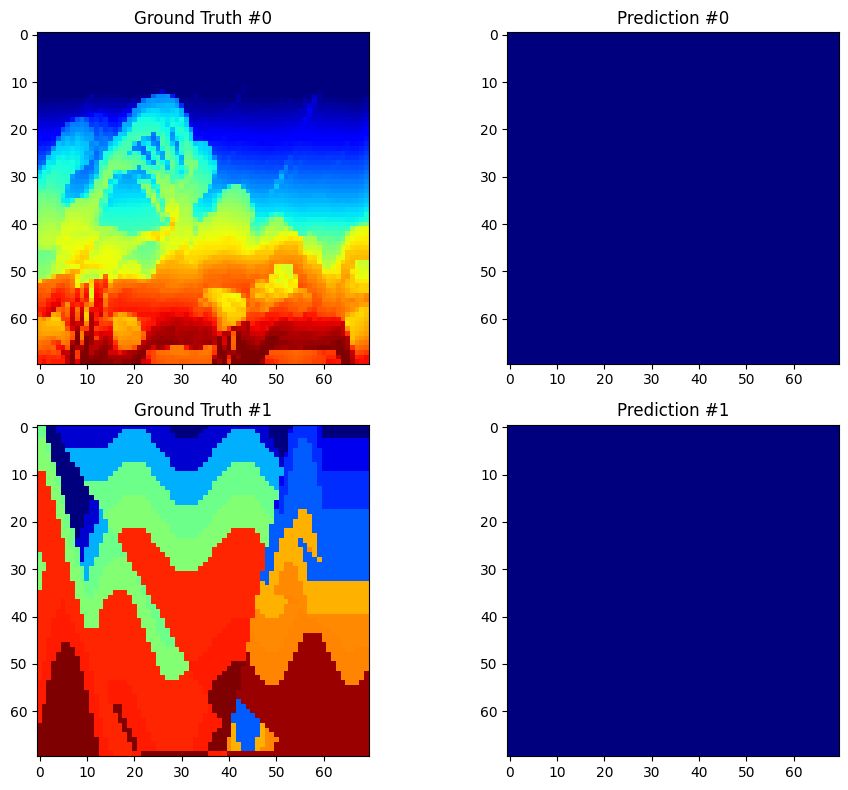

In [9]:
xb, yb = next(iter(val_loader))
xb = xb.to(device)
with torch.no_grad():
    v_pred = cnn(xb).cpu()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(2):
    axes[i, 0].imshow(yb[i, 0], cmap="jet", vmin=2000, vmax=4000)
    axes[i, 0].set_title(f"Ground Truth #{i}")
    axes[i, 1].imshow(v_pred[i, 0], cmap="jet", vmin=2000, vmax=4000)
    axes[i, 1].set_title(f"Prediction #{i}")
plt.tight_layout()
plt.show()